# class_logistic_regression.ipynb

## Data import and test

In [75]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
from sklearn.metrics import matthews_corrcoef
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn import model_selection

In [ ]:
name_data_file="heart_failure_clinical_records_dataset"

data = pd.read_csv(f"../../raw_data/{name_data_file}.csv", na_values=["?"])

X = data.drop(columns=["DEATH_EVENT",])
y = data["DEATH_EVENT"]

## Logistic Regression

### auxiliary functions

In [2]:
# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Random seed
seed = 42
np.random.seed(seed)
random.seed(seed)

def rocplot(p, y, ax=None, color="C0", label=None):
    """
    Plot the Receiver Operating Characteristic (ROC) curve and compute the AUC.

    Args:
        p (array-like): Predicted probabilities for the positive class.
        y (array-like): True binary class labels (0 or 1).
        ax (matplotlib.axes.Axes, optional): Axis to plot on.
        color (str, optional): Line color.
        label (str, optional): Label for the ROC curve.

    Returns:
        float: AUC
    """
    fpr, tpr, _ = metrics.roc_curve(y, p)
    auc_value = metrics.roc_auc_score(y, p)

    if ax is None:
        ax = plt.gca()

    ax.plot(fpr, tpr, color=color, lw=2, label=f"AUC = {auc_value:.3f}")
    ax.plot([0, 1], [0, 1], "k--", lw=1)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("False Positive Rate (1 - Specificity)")
    ax.set_ylabel("True Positive Rate (Sensitivity)")
    ax.set_title("ROC Curve")
    ax.grid(True, linestyle="--", alpha=0.5)
    if label or auc_value:
        ax.legend(loc="lower right")

    return auc_value

def confmatplot(y_true, y_pred, ax=None, cmap="Blues"):
    """
    Plot a styled confusion matrix.

    Args:
        y_true (array-like): True class labels.
        y_pred (array-like): Predicted class labels.
        ax (matplotlib.axes.Axes, optional): Axis to plot on.
        cmap (str, optional): Colormap for heatmap.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    acc = 100 * cm.diagonal().sum() / cm.sum()
    err = 100 - acc

    if ax is None:
        ax = plt.gca()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(f"Confusion Matrix\nAccuracy: {acc:.1f}%, Error: {err:.1f}%")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(np.arange(cm.shape[1]))
    ax.set_yticklabels(np.arange(cm.shape[0]))

    # Add counts in cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                f"{cm[i, j]}",
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10,
            )

    ax.grid(False)


### code

wiht regularization strength

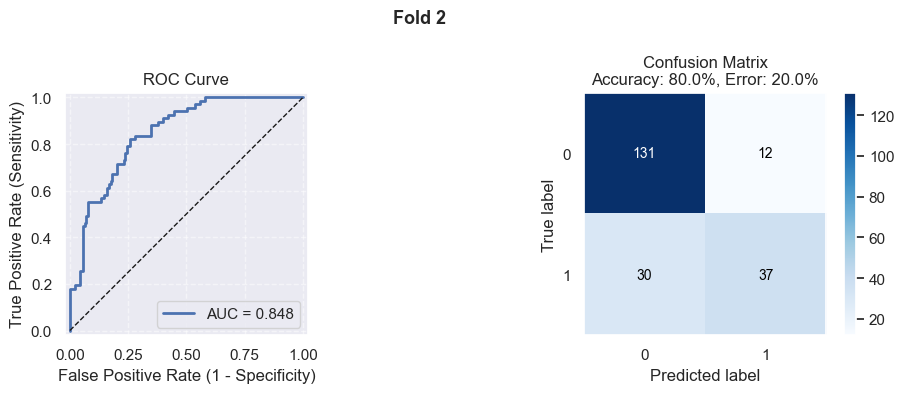

Matthews Correlation Coefficient (MCC): 0.516


In [116]:

regularization_strength = 6

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.70, stratify=y, random_state=42)
    
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

model = LogisticRegression(penalty="l2", C=1/regularization_strength) # Godinho work, as it´s done in the exercise_8
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
p = model.predict_proba(X_test)[:,1]
mcc = matthews_corrcoef(y_test, y_pred)

    # Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ROC curve
rocplot(p, y_test, ax=axes[0])

    # Confusion matrix
confmatplot(y_test, y_pred, ax=axes[1])

fig.suptitle(f"Fold {fold+1}", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()
print(f"Matthews Correlation Coefficient (MCC): {mcc:.3f}")


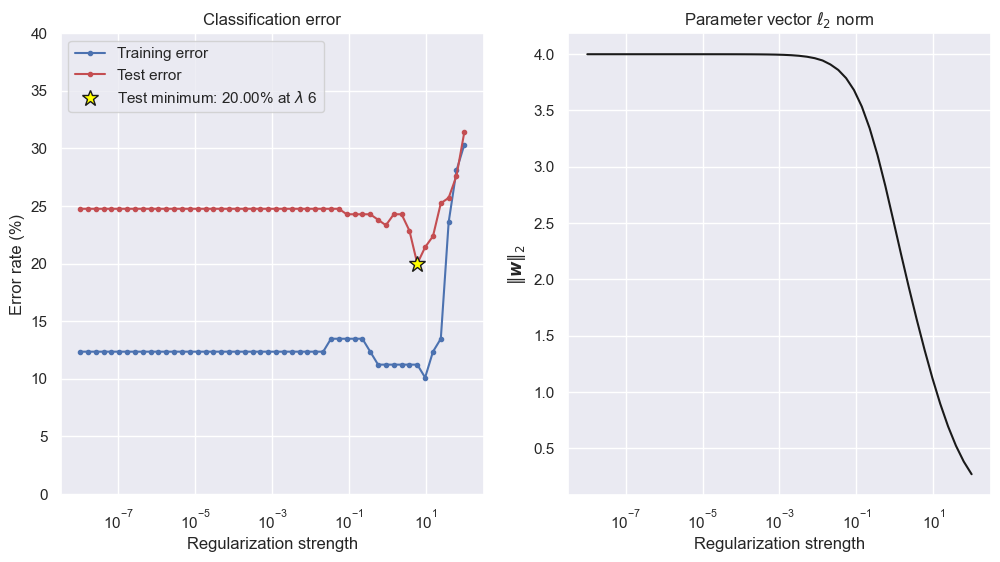

In [114]:
# Create crossvalidation partition for evaluation using stratification and 95 pct. split between training and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.70, stratify=y, random_state=42)

# Compute the mean and standard deviation of the training data split, then standardize the training and test sets
### BEGIN SOLUTION
# Compute the mean and standard deviation of training data split
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
# Standardize the training and test sets
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma
### END SOLUTION

# Select the range of regularization strengths to test
lambdas = np.logspace(-8, 2, 50)

# Setup storage for quantities computed in the experiment
train_error_rate = np.zeros(len(lambdas))
test_error_rate = np.zeros(len(lambdas))
coefficient_norm = np.zeros(len(lambdas))

# Loop over all values of the regularization strength
for i, regularization_strength in enumerate(lambdas):

    # Create and fit the regularized logistic regression model on the training set using the current regularization strength
    ### BEGIN SOLUTION
    model = LogisticRegression(penalty="l2", C=1/regularization_strength)
    model.fit(X_train, y_train)
    ### END SOLUTION

    # Predict on training and test set
    y_train_est = model.predict(X_train).T
    y_test_est = model.predict(X_test).T

    # Compute and store the training and test error rates
    train_error_rate[i] = np.sum(y_train_est != y_train) / len(y_train)
    test_error_rate[i] = np.sum(y_test_est != y_test) / len(y_test)

    # Compute and store the L2 norm of the model coefficients
    ### BEGIN SOLUTION
    coefficient_norm[i] = np.linalg.norm(model.coef_, ord=2)
    ### END SOLUTION

# Find the minimum test error and the corresponding regularization strength
min_error = np.min(test_error_rate)
opt_lambda_idx = np.argmin(test_error_rate)
opt_lambda = lambdas[opt_lambda_idx]


# Plot the results
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].semilogx(lambdas, train_error_rate * 100, 'b.-')
axs[0].semilogx(lambdas, test_error_rate * 100, 'r.-')
axs[0].semilogx(opt_lambda, min_error * 100, "*", color='yellow', markersize=12, markeredgecolor='k')
axs[0].set_xlabel("Regularization strength")
axs[0].set_ylabel("Error rate (%)")
axs[0].set_title("Classification error")
axs[0].set_ylim([-0.1, 40])
axs[0].legend(["Training error", "Test error", fr"Test minimum: {min_error*100:.2f}% at $\lambda$ {opt_lambda:.2g}"], loc="upper left")

axs[1].semilogx(lambdas, coefficient_norm, "k")
axs[1].set_ylabel("$\\|\\boldsymbol{w}\\|_2$")
axs[1].set_xlabel("Regularization strength")
axs[1].set_title(r"Parameter vector $\ell_2$ norm")
plt.show()



NO regularization strength - Ribau

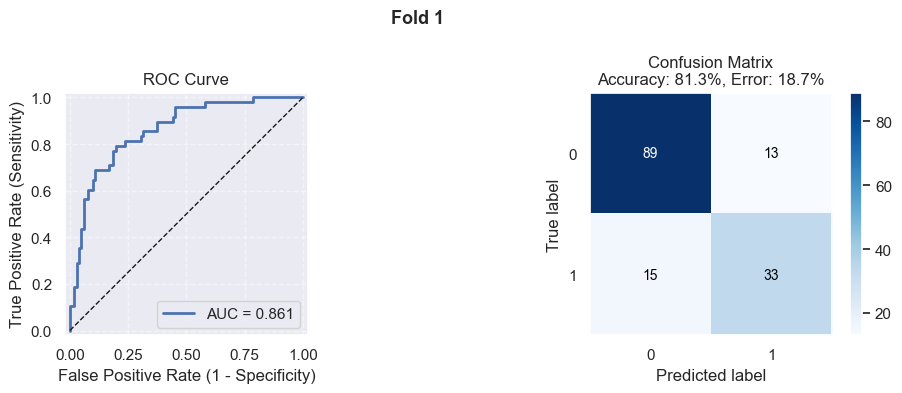

Matthews Correlation Coefficient (MCC): 0.567


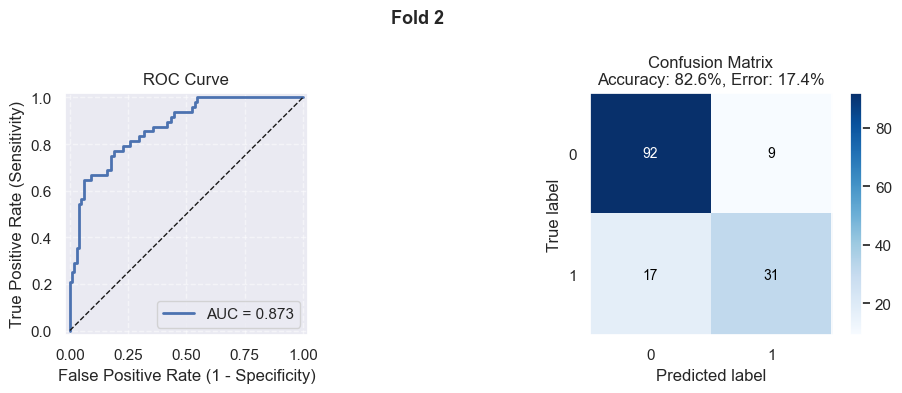

Matthews Correlation Coefficient (MCC): 0.587


In [66]:
K = 2

CV_kfold = StratifiedKFold(K, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(CV_kfold.split(X,y)):
    
    X_train, y_train = X.iloc[train_index,:], y[train_index]
    X_test, y_test = X.iloc[test_index,:], y[test_index]

    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    p = model.predict_proba(X_test)[:,1]
    mcc = matthews_corrcoef(y_test, y_pred)

    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ROC curve
    rocplot(p, y_test, ax=axes[0])

    # Confusion matrix
    confmatplot(y_test, y_pred, ax=axes[1])

    fig.suptitle(f"Fold {fold+1}", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.3f}")